# The Golden Ticket Idea
> ## Team: *Qurious Folks*
>> Developed by: Aman, Devesh, Vinay, Suman and Sachin 
<div align = "right"><img src="D.png" width=400, height= 200/></div>

---
$\newline$
**Aim:** Through this project, we aim to find a function of the given image using Quantum Machine Learning.

**Idea Description:** Given any 2D continuous picture (simple singular objects), We extracts the data points from the image (x,y points). We now try to find a function corresponding to the image. As we know almost any picture can have an associated function, and any function can be written in a Fourier series.

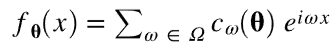

$\newline$
$\newline$

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit.providers.aer import QasmSimulator
from numpy import pi
from qiskit.circuit import Parameter, ParameterVector


In [2]:
import numpy as np
from numpy import pi, sin, cos, exp
import cmath

### Defining the input function

In [3]:
degree = 1
scaling = 1
coeffs = [0.15 + 0.15j]*degree
coeff0 = 0.1

#Generate a Fourier series.
def function(x):
    res = coeff0
    for i,c in enumerate(coeffs):
        exponent = complex(0, scaling*(i+1)*x)
        conj_c = np.conjugate(c)
        res += c * np.exp(exponent) + conj_c * np.exp(-exponent)
    return np.real(res)

In [4]:
#Original data points
x = np.linspace(-6,6,70)
y_0 = np.array([function(x_) for x_ in x])

### Defining the Quantum Model
> Here we'll define a quantum model using TwoLocal Ansatz coresseponding to the general fourier series.

We define a quantum model $f_\theta(x)$ as the expectation value of some observaable with respect to state prepared using parameterized quantum circuit, i.e.
<div><img src="b.jpeg", width = 350, height = 25/></div>

The $f_\theta(x)$ defined above as fourier series is equivalent to this expectation value.


In [5]:
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import CircuitStateFn, CircuitOp
import matplotlib.pyplot as plt

In [6]:
n = 2
qc = QuantumCircuit(n)
num_parameters = 8

In [7]:
#Data encoding circuit
def M(cir, x):
    for w in range(n):
        cir.rx(scaling*x, w)
    return cir

#Trainable circuit block (Defining the ansatz)
def U(theta):
    encode = TwoLocal(num_qubits = 2, reps = 1, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='full', insert_barriers=True)
    return encode.assign_parameters(theta)
    
#Defining the Quantum Model. Here we are mapping the data to the fourier series.
def Quantum_model(cir, weights, x=None):
    weights = weights.reshape(2,num_parameters)
    cir = cir.compose(U(weights[0]))
    cir = cir.compose(M(cir, x))        
    cir = cir.compose(U(weights[1]))
    cir = CircuitStateFn(cir)
    weights = weights.reshape(1,2*num_parameters)
    
    circuit = QuantumCircuit(2)
    circuit.z(0)
    op = CircuitOp(circuit)
    
    return (cir.adjoint().compose(op).compose(cir).eval().real)*scaling

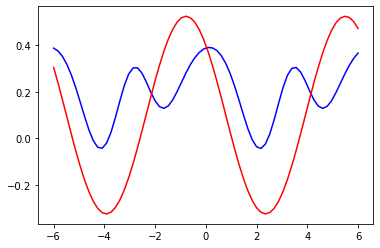

In [8]:
scaling = 1
weight = 2*np.pi*np.random.random(size = (1,2*num_parameters))

random_y = [Quantum_model(qc, weight, x = x_) for x_ in x]

plt.plot(x,random_y, c='blue')
plt.plot(x,y_0, c = 'red')

plt.show()

### Defining the cost function

In [9]:
def square_loss(targets, predictions):
    s = 0
    for t, p in zip(targets, predictions):
        s = s + (t - p) ** 2
    loss = s / 2*len(targets)
    return loss

def cost(weights):
    y = y_0
    predictions = [Quantum_model(qc,weights, x=x_) for x_ in x]
    return square_loss(y, predictions)

### Training the parameters
> Here we are optimizing the parameters using a classical optimizer from `scipy.optimize`.

In [10]:
import scipy.optimize as op
weight2 = op.fmin(lambda w: cost(w), weight, xtol=0.0001, ftol=0.0001, maxiter=100,
                  maxfun=None, full_output=0, disp=1, retall=0, callback=None)

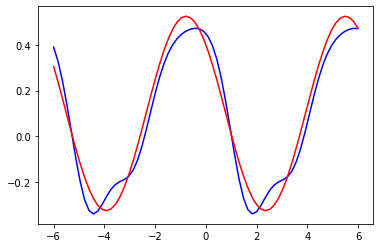

In [11]:
new_weights = np.array(weight2)
trained_y = [Quantum_model(qc, new_weights, x = x_) for x_ in x]

plt.plot(x, trained_y, c='blue')
plt.plot(x,y_0, c = 'red')

plt.show()

### Sampling Fourier coefficient

In [12]:
#Computes the first 2*K+1 Fourier coefficients of a 2*pi periodic function.

def fourier_coefficients(f, K):
    n_coeffs = 2*K+1
    t = np.linspace(0, 2*np.pi, n_coeffs, endpoint=False)
    y = np.fft.rfft(f(t)) / t.size
    return y

In [13]:
n_coeffs = len(new_weights)
n_samples = 100

coeffs = []
def f(x):
    return np.array([Quantum_model(qc, new_weights, x=i) for i in x])

coeffs_sample = fourier_coefficients(f, n_coeffs)
coeffs.append(coeffs_sample)

coeffs = np.array(coeffs)
coeffs_real = np.real(coeffs)
coeffs_imag = np.imag(coeffs)

### Display the coefficients of fourier series obtained after training

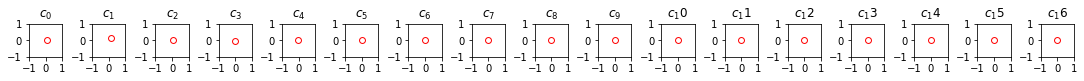

In [14]:
n_coeffs = len(coeffs_real[0])

fig, ax = plt.subplots(1, n_coeffs, figsize=(15,4))

for idx, ax_ in enumerate(ax):
    ax_.set_title(r"$c_{}$".format(idx))
    ax_.scatter(coeffs_real[:, idx], coeffs_imag[:, idx], s=35, facecolor='white', edgecolor='red')
    ax_.set_aspect("equal")
    ax_.set_ylim(-1, 1)
    ax_.set_xlim(-1, 1)


plt.tight_layout(pad=0.5)
plt.show()

## Conclusion

After training the above model for several different input images/data-sets, we draw the following conclusions:  
> - Fourier series for any given image or curve can be obtained provided a good ansatz and an apropriate optimiser is used.
> - Different input images required different ansatzs.
> - Time taken in training the model for a given image depends on the DPI of the image, higher the pixle density more the time taken.

